In this analysis, we apply a density estimator based on normalizing flows to perform anomaly detection using the Gaia DR2 dataset, which contains a mixture of "signal" and "background" stars. The dataset is subdivided into rotostreams (PS's), protoclusters (PC's), and search regions (SR's), which represent different subsets of stars.

A normalizing flow model is trained on a section of the dataset.
An anomaly score 𝑅 is computed for each star, combining the results from two density estimators: one for the full distribution (signal + background) and one for the background distribution alone.
By adjusting the threshold on 𝑅, we can increase the "signal" strength by identifying more unusual (anomalous) data points.
For a detailed explanation of the algorithm, please refer to this paper: D Shih, M Buckley, L Necib, Via Machinae 2.0: Full-Sky, Model-Agnostic Search for Stellar Streams in Gaia DR2, 2023 (https://arxiv.org/abs/2303.01529).

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

import sys
sys.path.insert(1, "/het/p4/rporto/ViaMachinaePos/plots")
sys.path.insert(1, "/het/p4/rporto/ViaMachinaePos/code")


from data_loader import getPCpos, getSRdata, load_gaiadata, loadRvals, rotate_data

In [2]:
# Load stream candidate

streamsFile = "/het/p4/rporto/fullsky_streams/streams_lwr5_lwtheta3_pcsig8.pkl"
vm1 = np.load(streamsFile, allow_pickle=True)[:102][6]
unique_SRs = np.int16(np.array([s.strip().split() for s in open('/het/p4/rporto/condor/stream_7_pos_SRs.list').readlines()]))

Protostream (PS), protocluster (PC), and search region (SR) are different subdivisions of the dataset. Here we load anomaly score (R) values for all data within a specific PC

In [3]:
# Load results for a single protocluster (PC)

def load_results(ps, pc, SRwidth, resultsdir):
    dataset, SRstart, rotangle = getPCpos(pc, SRwidth)
    SRend = np.round(SRstart+SRwidth,2)
    Rvals = loadRvals(resultsdir, pc, SRwidth=SRwidth)

    # SRstars cols: pm_lat, pm_lon_coslat, lon, lat, color, mag, pmdec, pmra, dec, ra, sourceid, R
    SRstars, fidmask = getSRdata(dataset, Rvals, SRstart, SRend, coorduse='lat', rotangle=rotangle, includeRaDec=True)
    rotate_data(SRstars, -rotangle, 3, 2)
    # Fiducial cuts are applied to filter out stars that are very unlikely to be part of a signal
    filteredstars = SRstars[fidmask]
    sortedstars = filteredstars[filteredstars[:,-1].argsort()][::-1]

    # Collect all line stars in the SR. Line stars are the "signal"
    linestars = []
    for pc in ps.pclist:
        # cols: pmdec, pmra, dec, ra, color, mag, lon, lat, pm_lon_coslat, and pm_lat, parallax, parallax_error
        linestars += list(pc.highRstars[pc.line_stars])
    # Get rid of duplicates and rearrange so cols match SRstars
    linestars = np.unique(linestars, axis=0)[:,[9,8,6,7,4,5,0,1,2,3]]

    rotate_data(linestars, rotangle, lat_i=3, lon_i=2)
    innermask = (linestars[:,3] > SRstart) & (linestars[:,3] < SRend)
    linestars = linestars[innermask]
    _=rotate_data(linestars, -rotangle, lat_i=3, lon_i=2)

    return SRstars, filteredstars, sortedstars, linestars

In [4]:
resultsdir = '/het/p4/rporto/results_VMpos/run_2/' # Directory containing anomaly scores for all stars in the dataset
SRwidth = 3

# Most significant protocluster in vm1
ps = vm1.protostreams[np.argmax([ps.line_sigma for ps in vm1.protostreams])]
pc = ps.pclist[0] 

dataset, SRstart, rotangle = getPCpos(pc, SRwidth)
SRstars, filteredstars, sortedstars, linestars = load_results(ps, pc, SRwidth, resultsdir)

To evaluate the model's performance, we first plot the training loss and validation loss over time

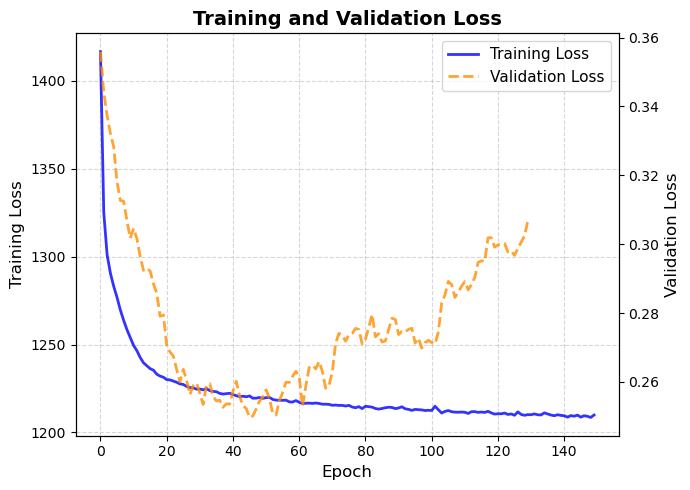

In [5]:
# Read training loss
mode = "inner"
log = open(resultsdir + f"/output/log_train_{mode}_{dataset}_lat_{SRstart}_rot{rotangle}").readlines()
loss = np.float64(np.array([l.strip() for l in log[4::5]]))

# Read validation loss
Ravg = open(resultsdir + f"{dataset}/bestepoch_{dataset}_{SRstart}_rot{rotangle}").readlines()[2].strip()
Ravg = np.float64(np.array(Ravg[1:-1].split(",")))

fig, ax1 = plt.subplots(figsize=(7, 5))  # Adjust size

# Training loss
ax1.plot(loss, label="Training Loss", color="blue", linestyle="-", linewidth=2, alpha=0.8)
ax1.set_ylabel("Training Loss", fontsize=12)
ax1.set_xlabel("Epoch", fontsize=12)
ax1.tick_params(axis="y")

# Validation loss
ax2 = ax1.twinx()
ax2.plot(Ravg, label="Validation Loss", color="darkorange", linestyle="--", linewidth=2, alpha=0.8)
ax2.set_ylabel("Validation Loss", fontsize=12)
ax2.tick_params(axis="y")

ax1.grid(True, linestyle="--", alpha=0.5)

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc="upper right", fontsize=11, frameon=True)

plt.title("Training and Validation Loss", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.savefig('train_val_loss.png')
plt.show()


Next, we use the trained model to generate samples of stars from the distribution and compare them to the real data:

In [6]:
# Define methods for loading trained models and generating samples

import torch
import torch.nn as nn
import torch.utils.data
import flows as fnn

def load_models(resultsdir, mode, pc, SRwidth, navg=1):

    models = []

    dataset, SRstart, rotangle = getPCpos(pc, SRwidth)
    SRend = np.round(SRstart+SRwidth,2)

    num_blocks = 20
    num_hidden = 64

    CUDA = False
    device = torch.device("cuda:0" if CUDA else "cpu")

    datadir='/het/p4/mbuckley/density_estimation/Gaia_data/Gaia_data_redownloaded_merged/'
    gaiadata2=load_gaiadata(datadir+'/'+dataset, rotangle, cutRadius=False)

    icoord = 3
    innermask=(gaiadata2[:,icoord]>float(SRstart)) & (gaiadata2[:,icoord]<float(SRend))
    outermask=~innermask

    bestepoch = int(open(resultsdir+dataset+'/bestepoch_'+dataset+'_'\
                    +str(SRstart)+'_rot'+str(rotangle)).readlines()[-1].strip().split()[-1])

    for i in range(navg):
        if mode == 'inner':
            modeldir = resultsdir+dataset+"/inner_"+dataset+"_lat_"\
                        +str(SRstart)+"_"+str(SRend)+"_rot"+str(rotangle)+"_epoch_"+str(bestepoch)+"_Model.par"
            labels = torch.from_numpy(gaiadata2[innermask][:,icoord:icoord+1])
            tensor = torch.from_numpy(np.delete(gaiadata2[innermask],icoord,axis=1))
        elif mode == 'outer':
            modeldir = resultsdir+dataset+"/outer_"+dataset+"_lat_"\
                        +str(SRstart)+"_"+str(SRend)+"_rot"+str(rotangle)+"_epoch_"+str(bestepoch)+"_Model.par"
            labels = torch.from_numpy(gaiadata2[outermask][:,icoord:icoord+1])
            tensor = torch.from_numpy(np.delete(gaiadata2[outermask],icoord,axis=1))
        else:
            print('Mode must be inner or outer')

        bestepoch += 1
        
        num_inputs = tensor.shape[-1]
        num_cond_inputs = labels.shape[-1]

        act = 'relu'

        modules = []
        for _ in range(num_blocks):
            modules += [
                fnn.MADE(num_inputs, num_hidden, num_cond_inputs, act=act),
                fnn.BatchNormFlow(num_inputs),
                fnn.Reverse(num_inputs)
            ]

        model = fnn.FlowSequential(*modules)
        for module in model.modules():
            if isinstance(module, nn.Linear):
                nn.init.orthogonal_(module.weight)
                if hasattr(module, 'bias') and module.bias is not None:
                    module.bias.data.fill_(0)
        model.to(device)

        model.load_state_dict(torch.load(modeldir, map_location='cpu'))
        model.eval()
        models.append(model)

    return tensor, labels, models


def make_samples(num_samples, tensor, labels, model, rand=None):

    samples = []

    if type(model) != list:
        model = [model]

    if rand == None:
        rand = torch.randperm(len(labels))

    slices = np.int32(np.linspace(0,num_samples,len(model)+1))
    for i in range(len(model)):
        labels_use = labels[rand][slices[i]:slices[i+1]]

        model_samples = model[i].sample(noise = torch.Tensor(slices[i+1]-slices[i], 5).normal_(),
                            cond_inputs = labels_use)
        samples.append(model_samples.detach().numpy())

    samples = np.reshape(np.array(samples),(num_samples,5))

    # Undo preprocessing
    std = np.std(tensor.detach().numpy(), axis=0)
    mean = np.mean(tensor.detach().numpy(),axis=0)
    samples = (samples * std) + mean

    data = tensor[rand][:num_samples].detach().numpy()

    return samples, data

Feature histograms of generated data are similar to those of the real data, but there is room for improvement

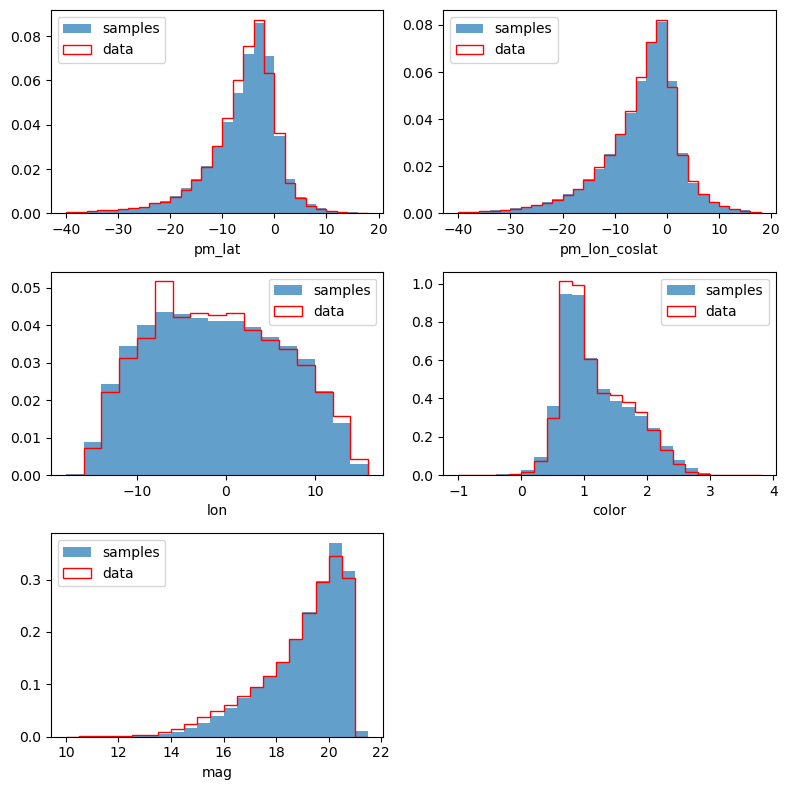

In [7]:
num_samples = 40000
mode = 'outer'

resultsdir = '/het/p4/rporto/results_VMpos/run_2/'
SRwidth = 3

dataset, SRstart, rotangle = getPCpos(pc, SRwidth)
figname = '/het/p4/rporto/ViaMachinaePos/plots/feature_histograms/'+mode+'_'+dataset+'_'+str(SRstart)+'_'+'_rot'+str(rotangle)+'.png'

inner_tensor, inner_labels, inner_model = load_models(resultsdir, mode, pc, SRwidth)
rand = torch.randperm(len(inner_labels)) # Choose same subset of data for all plots
samples, data = make_samples(num_samples, inner_tensor, inner_labels, inner_model, rand)


features = ('pm_lat', 'pm_lon_coslat', 'lon', 'color', 'mag')

num_features = 5

fig, ax = plt.subplots(3,2,tight_layout=True)
fig.set_size_inches(8,8)

bins = [np.arange(-40,20,2),
        np.arange(-40,20,2),
        np.arange(-18,18,2),
        np.arange(-1,4,0.2),
        np.arange(10,22,0.5)]

for ii in range(num_features):
        axs=ax[ii//2,ii%2]
        axs.hist(samples[:,ii],
                bins=bins[ii],
                alpha=0.7,
                label='samples',
                density=True
                )
        axs.hist(data[:,ii],
                bins=bins[ii],
                #  alpha=0.5,
                label='data',
                density=True,
                histtype=u'step',
                color='red'
                )
        axs.set_xlabel(features[ii])
        axs.legend()

# Hide unused subplots
ax = ax.flatten()
for i in range(num_features, len(ax)):
    ax[i].axis("off")

plt.savefig('generated_features.png')
fig.show()

We evaluate the performance of our model using a Gradient Boosting Classifier to distinguish between the synthetic and real data:

In [8]:
# Define methods used for evaluating model performance

from sklearn.ensemble import GradientBoostingClassifier


def train_bdt(data, samples, num_train):
    num_test = len(samples) - num_train

    X_train, X_test = np.concatenate((data[:num_train], samples[:num_train])), np.concatenate((data[num_train:], samples[num_train:]))
    y_train, y_test = np.concatenate((np.ones(num_train), -np.ones(num_train))), np.concatenate((np.ones(num_test), -np.ones(num_test)))

    clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
        max_depth=1, random_state=0).fit(X_train, y_train)
    return clf.score(X_test, y_test)

def calculate_auc(resultsdir, mode, pc, SRwidth, num_samples, train_split=0.75, navg=20, edge_mask=0):

    if mode == 'interpolate':
        model_use = 'outer'
        label_use = 'inner'
    elif mode == 'inner' or mode == 'outer':
        model_use = mode
        label_use = mode
    else:
        print('Mode must be "inner", "outer", or "interpolate"')

    tensor, labels, models = load_models(resultsdir, label_use, pc, SRwidth, navg)
    if model_use != label_use:
        models = load_models(resultsdir, model_use, pc, SRwidth, navg)[2]
    samples, data = make_samples(num_samples, tensor, labels, models)
    samples = samples[~np.isnan(samples).any(axis=1) & ~np.isinf(samples).any(axis=1), :]

    data_mins = np.percentile(np.concatenate((data, samples)), 0+edge_mask, axis=0)
    data_maxs = np.percentile(np.concatenate((data, samples)), 100-edge_mask, axis=0)
    data_mask = np.all(data<=data_maxs, axis=1) & np.all(data>=data_mins, axis=1)
    samples_mask = np.all(samples<=data_maxs, axis=1) & np.all(samples>=data_mins, axis=1)

    data = data[data_mask]
    samples = samples[samples_mask]

    num_train = np.int32(train_split*np.min([len(data),len(samples)]))

    return train_bdt(data, samples, num_train)

The binary decision tree classifies real vs generated data with ~52.3% accuracy

In [10]:
resultsdir = '/het/p4/rporto/results_VMpos/run_6/' # SRwidth = 1.6, 300 epochs
SRwidth = 1.6
ps = vm1.protostreams[np.argmax([ps.line_sigma for ps in vm1.protostreams])]
pc = ps.pclist[0]
num_samples = 40000

print(calculate_auc(resultsdir, 'inner', pc, SRwidth, num_samples))

0.528


In [15]:
resultsdir = '/het/p4/rporto/results_VMpos/run_2/' # Directory containing anomaly scores for all stars in the dataset
SRwidth = 3

# Most significant protocluster in vm1
ps = vm1.protostreams[np.argmax([ps.line_sigma for ps in vm1.protostreams])]
pc = ps.pclist[0] 

dataset, SRstart, rotangle = getPCpos(pc, SRwidth)
SRstars, filteredstars, sortedstars, linestars = load_results(ps, pc, SRwidth, resultsdir)

We see that initially the data has a relatively small signal strength compared to the background

In [16]:
# S/B and S/sqrt(B) for the SR before any fiducial cuts or R cuts

print('S/B:', np.round(len(linestars)/(len(SRstars) - len(linestars)), 4))
print('S/sqrt(B):', np.round(len(linestars)/np.sqrt((len(SRstars) - len(linestars))), 4))

S/B: 0.0022
S/sqrt(B): 0.7217


The peak of the significance improvement coefficient (SIC) curve (which scans across different cuts on R) is around 2.3, indicating that the anomaly score R is fairly good at distinguishing signal from background

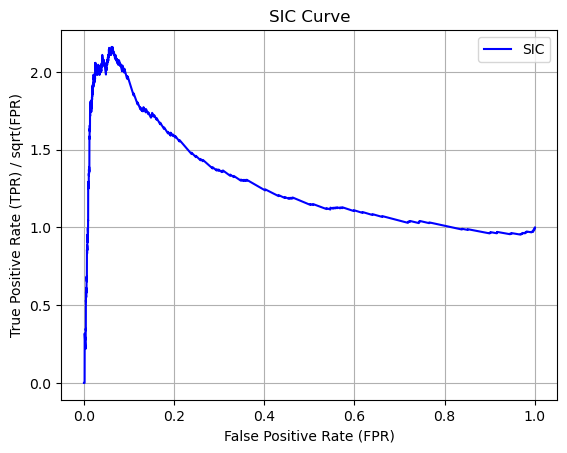

In [17]:
from sklearn.metrics import roc_curve

difflist = []
linestars_indlist = []

# Find linestars with a small margin of error
for star in linestars:
    diffs = np.sum((filteredstars[:, :-2] - star)**2, axis=1)
    mindiff = np.min(diffs)
    ind = np.argmin(diffs)
    difflist.append(mindiff)
    
    # If the minimum difference is smaller than a threshold, store the index
    if mindiff < 1e-10:
        linestars_indlist.append(ind)

truth_labels = np.zeros(len(filteredstars))
truth_labels[linestars_indlist] = 1

# Compute the ROC curve
fpr, tpr, _ = roc_curve(truth_labels, filteredstars[:, -1])

plt.plot(fpr, tpr / np.sqrt(fpr), label="SIC", color="b")
plt.title("SIC Curve")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR) / sqrt(FPR)")
plt.legend(loc="best")
plt.grid(True)
plt.savefig('sic_curve.png')
plt.show()


Plotting the distribution of R values for signal vs background stars, we see that the signal stars are clearly assigned higher anomaly scores overall, indicating that the algorithm can successfully "purify" the data

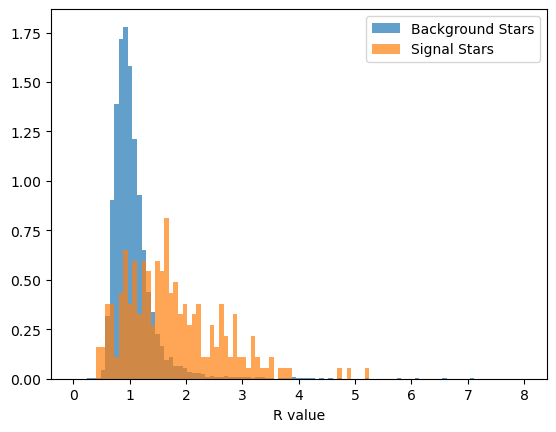

In [18]:
# Plot distribution of R for both signal and background stars

sigstars = []
bgdstars = []

# Separate stars into signal and background categories
for star in filteredstars:
    if (linestars == np.float32(star[:-2])).all(axis=1).any():
        sigstars.append(star)
    else:
        bgdstars.append(star)

sig = len(sigstars)
bgd = len(bgdstars)

sigstars = np.array(sigstars)
bgdstars = np.array(bgdstars)

bins = np.linspace(0, 8, 100)


# Plot histograms for both background and signal stars
plt.hist(bgdstars[:, -1], bins=bins, alpha=0.7, density=True, label='Background Stars')
plt.hist(sigstars[:, -1], bins=bins, alpha=0.7, density=True, label='Signal Stars')

plt.xlabel("R value")
plt.legend()
plt.savefig('signal_background.png')
plt.show()
